In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter # Para formatear los ejes
import seaborn as sb

### Carga de datos

In [2]:
# Visualiza las 23 columnas
pd.set_option('display.max_columns', 23)
# Carga del CSV en un DataFrame df (usando como delimitador la coma ',')
df = pd.read_csv('train.csv')

Para los datos renombrados y reordenados se va a usar el DataFrame dfok.

In [3]:
# Se renombran las columnas
nombresNuevos = {
                 'id' : 'ID',
                 'titulo' : 'Titulo',
                 'descripcion' : 'Descripcion',
                 'tipodepropiedad' : 'TipoPropiedad',
                 'direccion' : 'Direccion',
                 'ciudad' : 'Ciudad',
                 'provincia' : 'Provincia',
                 'antiguedad' : 'Antiguedad',
                 'habitaciones' : 'CantHabitaciones',
                 'garages' : 'CantGarages',
                 'banos' : 'CantBanos',
                 'metroscubiertos' : 'MetrosCuadradosCubiertos',
                 'metrostotales' : 'MetrosCuadradosTotales',
                 'idzona' : 'IDZona',
                 'lat' : 'Latitud',
                 'lng' : 'Longitud',
                 'fecha' : 'Fecha',
                 'gimnasio' : 'TieneGimnasio',
                 'usosmultiples' : 'TieneUsosMultiples',
                 'piscina' : 'TienePileta',
                 'escuelascercanas' : 'TieneEscuelasCerca',
                 'centroscomercialescercanos' : 'TieneShoppingsCerca',
                 'precio' : 'Precio'
                
}
dfok = df.rename(columns = nombresNuevos)

In [4]:
# Se Reordenan las columnas
nombresEnOrden = [
                 'ID',
                 'Titulo',
                 'TipoPropiedad',
                 'Precio',
                 'Fecha',
                 'Antiguedad',
                 'MetrosCuadradosCubiertos',
                 'MetrosCuadradosTotales',
                 'Descripcion',
                 
                 'CantHabitaciones',
                 'CantGarages',
                 'CantBanos',
               
                 'IDZona',
                 'Direccion',
                 'Ciudad',
                 'Provincia',
                 'Latitud',
                 'Longitud',
                 
                 'TieneGimnasio',
                 'TieneUsosMultiples',
                 'TienePileta',
                 'TieneEscuelasCerca',
                 'TieneShoppingsCerca'
    ]                 
dfok = dfok[nombresEnOrden];

### Análisis de propiedades por sus comodidades

Se va a analizar la relación entre la provincia y la cantidad de tipos de comodidad de las propiedades.

In [5]:
columnas = ['Ciudad',
            'Provincia',
            'TieneGimnasio',
            'TieneUsosMultiples',
            'TienePileta',
            'TieneEscuelasCerca',
            'TieneShoppingsCerca',
            'Precio'] 
df_abool = dfok[columnas].copy()

En el análisis exploratorio de Navent se indica que los nombres de ciudades y provincias son String, el precio se representa con tipo entero y las demás columnas de comodidades son Booleanas. 

Se crea un nuevo DataFrame df_abool que copia columnas de interés del DataFrame original.

### Análisis de calidad de datos

In [6]:
print(df_abool.isnull().sum())
memoria_usada = df_abool.memory_usage()
print('\nTotal memoria usada sin cambios de tipos {:.2f}'.format(memoria_usada.sum()/1024/1024), 'MB')

Ciudad                 372
Provincia              155
TieneGimnasio            0
TieneUsosMultiples       0
TienePileta              0
TieneEscuelasCerca       0
TieneShoppingsCerca      0
Precio                   0
dtype: int64

Total memoria usada sin cambios de tipos 14.65 MB


Aparecen valores nulos en las columnas Ciudad y Provincia. Se verifica si hay alguna relación entre los valores nulos de provincias y ciudades. Para esto se ubican los casos en que ambos son nulos.

Aparecen valores nulos en las columnas Ciudad y Provincia. Se verifica si hay alguna relación entre los valores nulos de provincias y ciudades. Para esto se ubican los casos en que ambos son nulos.

In [7]:
df_abool[(df_abool['Ciudad'].isnull() == True) & (df_abool['Provincia'].isnull() == True)].isnull().sum()

Ciudad                 155
Provincia              155
TieneGimnasio            0
TieneUsosMultiples       0
TienePileta              0
TieneEscuelasCerca       0
TieneShoppingsCerca      0
Precio                   0
dtype: int64

Antes se tenía 155 casos de Provincia nulos, pero aquí se ve que ésos valores también tienen ciudades nulas. Como se van utilizar estos valores conviene descartarlos.

In [8]:
df_abool.dropna(subset=['Provincia'], inplace=True)
df_abool.isnull().sum()

Ciudad                 217
Provincia                0
TieneGimnasio            0
TieneUsosMultiples       0
TienePileta              0
TieneEscuelasCerca       0
TieneShoppingsCerca      0
Precio                   0
dtype: int64

A continuación se verifica qué proporción de valores nulos de ciudades por provincia queda, para ver si es correcto eliminarlas.

In [9]:
# Se crea un DataFrame donde solo se almacenan los casos con valores nulos de ciudades
cant_nulos_provincia = df_abool.loc[df_abool['Ciudad'].isnull() == True].copy() # Devuelve un DataFrame
# Se elije solo la columna Provincia y se realiza un conteo. Devuelve una Serie
cant_nulos_provincia = cant_nulos_provincia['Provincia'].value_counts() # Devuelve una Serie
# Se transforma la Serie a DataFrame
cant_nulos_provincia = cant_nulos_provincia.to_frame()
# Se resetea el índice para tener una columna con el nombre de las provincias
cant_nulos_provincia.reset_index(inplace = True)
# Se cambia el nombre a la columna de las provincias
cant_nulos_provincia.rename(columns = {'index' : 'Provincia', 'Provincia' : 'cant_nulos'}, inplace = True)
# Se ordena alfabéticamente por nombre de provincia
cant_nulos_provincia.sort_values(by='Provincia', ascending = True, inplace = True)
cant_nulos_provincia.reset_index(drop = True, inplace=True)

Con esto se tiene un DataFrame con una columna con los nombres de las provincias y otra con la cantidad correspondiente de ciudades nulas.

Luego se crea un DataFrame con la cantidad total de casos por provincia, que luego que compara con los casos nulos.

In [10]:
cant_total_provincia = df_abool['Provincia'] # Devuelve una Serie
# Se convierto a DataFrame
cant_total_provincia = cant_total_provincia.value_counts().to_frame()
# Se resetea el índice para tener una columna con el nombre de las provincias
cant_total_provincia.reset_index(inplace = True)
# Se cambia el nombre a la columna de las provincias
cant_total_provincia.rename(columns = {'index' : 'Provincia', 'Provincia' : 'cant_total'}, inplace = True)
# Se ordena alfabéticamente por nombre de provincia
cant_total_provincia.sort_values(by = 'Provincia', ascending = True, inplace = True)
cant_total_provincia.reset_index(drop = True, inplace = True)

El DataFrame `cant_total_provincia` tiene una columna con los nombres de las provincias y otra con la cantidad total de provincias.

### Merge de `cant_nulos_provincia` con `cant_total_provincia`

1. DataFrame izquierdo `cant_nulos_provincia`
- DataFrame derecho `cant_total_provincia`
 
La unión se realiza sobre la columna Provincia.

In [11]:
df_joined = pd.merge(cant_nulos_provincia, cant_total_provincia, on='Provincia', how = 'inner')

Como en `cant_nulos_provincia` había ceros (casos de provincias sin valores nulos), se seleccionan solo los casos distintos de cero. Recordar que se quiere eliminar los nulos.

In [12]:
df_joined = df_joined.loc[df_joined['cant_nulos'] != 0].copy()
df_joined.reset_index(drop = True, inplace = True)
# Ya se tiene un DataFrame para calcular la proporción de los valores nulos en los totales (por provincia)

Ahora se agrega una columna de proporciones.

In [13]:
df_joined['propor_nulos [%]'] = df_joined['cant_nulos'] / df_joined['cant_total'] * 100
# Se redondea a dos decimales
df_joined['propor_nulos [%]'] = df_joined['propor_nulos [%]'].round(2)
df_joined

,Provincia,cant_nulos,cant_total,propor_nulos [%]
0,Chihuahua,46,4590,1.00
1,Distrito Federal,20,58790,0.03
2,Durango,1,2275,0.04
3,Edo. de México,18,41607,0.04
4,Guanajuato,3,2860,0.10
5,Guerrero,3,2678,0.11
6,Jalisco,21,21238,0.10
7,Morelos,2,7337,0.03
8,Nuevo León,9,15324,0.06
9,Oaxaca,3,711,0.42


Se ve que no representan más del 1% de los casos totales. Enonces se pueden eliminar.

In [14]:
df_abool.dropna(inplace = True)

Ahora se tiene `df_abool` sin casos nulos.

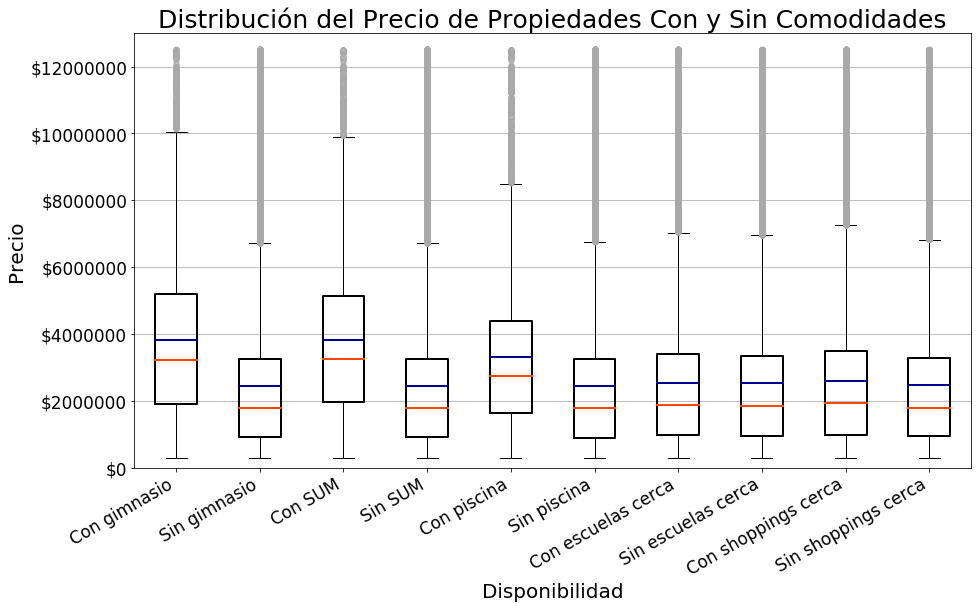

In [15]:
plt.figure(figsize = (15,8))
plt.xticks(fontsize = 17, rotation = 30, ha = 'right')
plt.yticks(fontsize = 17)
plt.ylim([0, 13000000])
#sb.set(style = 'whitegrid')
plt.title("Distribución del Precio de Propiedades Con y Sin Comodidades", fontsize = 25)
plot = plt.boxplot([df_abool.loc[df_abool['TieneGimnasio'] == True]['Precio'], \
                    df_abool.loc[df_abool['TieneGimnasio'] == False]['Precio'], \
                    df_abool.loc[df_abool['TieneUsosMultiples'] == True]['Precio'], \
                    df_abool.loc[df_abool['TieneUsosMultiples'] == False]['Precio'], \
                    df_abool.loc[df_abool['TienePileta'] == True]['Precio'], \
                    df_abool.loc[df_abool['TienePileta'] == False]['Precio'], \
                    df_abool.loc[df_abool['TieneEscuelasCerca'] == True]['Precio'], \
                    df_abool.loc[df_abool['TieneEscuelasCerca'] == False]['Precio'], \
                    df_abool.loc[df_abool['TieneShoppingsCerca'] == True]['Precio'], \
                    df_abool.loc[df_abool['TieneShoppingsCerca'] == False]['Precio']], 
                   labels = ['Con gimnasio', 'Sin gimnasio', \
                             'Con SUM', 'Sin SUM', \
                             'Con piscina', 'Sin piscina', \
                             'Con escuelas cerca', 'Sin escuelas cerca', \
                             'Con shoppings cerca', 'Sin shoppings cerca'],
                   widths = 0.5, \
                   meanline = True, showmeans=True, \
                   boxprops = dict(linewidth=2), \
                   meanprops = dict(linestyle = '-', linewidth=2, color = 'darkblue'), \
                   # linestyle = '-' muestra la media con línea sólida
                   flierprops = dict(marker='o', markerfacecolor='none', markersize=5, \
                                     linestyle='none', markeredgecolor = 'darkgrey'), \
                   medianprops = dict(linestyle = '-', linewidth=2, color='orangered'))
plt.xlabel('Disponibilidad', fontsize = 20)
plt.ylabel('Precio', fontsize = 20)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.gca().yaxis.grid(True)
#sb.set(style = 'white')
plt.show()

Observando las comodidades propias de las propiedades (gimnasio, Salón de usos múltiples y piscina), se nota que los precios aumentan, lo que es esperable.

La cercanía a comodidades compartidas (escuelas y centros comerciales) no modifica de manera apreciable el valor medio del precio de las propiedades.

In [16]:
# Se cuentan las propiedades con comodidades exclusivas.
solo_gimnasio = len(df_abool.loc[(df_abool['TieneGimnasio'] == True) & \
                                 (df_abool['TieneUsosMultiples'] == False) & \
                                 (df_abool['TienePileta'] == False)])

solo_sum = len(df_abool.loc[(df_abool['TieneGimnasio'] == False) & \
                            (df_abool['TieneUsosMultiples'] == True) & \
                            (df_abool['TienePileta'] == False)])

solo_piscina = len(df_abool.loc[(df_abool['TieneGimnasio'] == False) & \
                                (df_abool['TieneUsosMultiples'] == False) & \
                                (df_abool['TienePileta'] == True)])

print('Solo con gimnasio:', solo_gimnasio, \
      '\nSolo con salón de usos múltiples:', solo_sum, \
      '\nSolo con piscina:', solo_piscina)
proporcion = (solo_gimnasio + solo_sum + solo_piscina)*100/len(dfok)
print('Proporción de estos casos respecto del total:', round(proporcion,2), '%')

Solo con gimnasio: 5614 
Solo con salón de usos múltiples: 4987 
Solo con piscina: 11690
Proporción de estos casos respecto del total: 9.29 %


Como son muy pocos casos se va a tratar la distribuciones de comodidades de manera inclusiva, sin preocupación de si tienen o no otro tipo de amenidad.

In [17]:
# Se referencian los datos para los distintos gráficos.
con_gimnasio = df_abool.loc[df_abool['TieneGimnasio'] == 1]
con_sum = df_abool.loc[df_abool['TieneUsosMultiples'] == 1]
con_piscina = df_abool.loc[df_abool['TienePileta'] == 1]

A continuación se generan DataFrames para tener una lista ordenada con los nombres de las provincias:
1. Se arma un DataFrame agrupando por `Provincia` y realizando una agregación por media de `Precio`;
- Se le cambia el nombre a la columna `{'Precio':'Media Precio'}`;
- Se ordena de mayor a menor por `Media Precio`;
- Se resetea el índice para tener una columna `Provincia` con los nombres de las provincias.


In [18]:
con_gimnasio_orden_media = con_gimnasio.groupby('Provincia').agg({'Precio':'mean'})
con_gimnasio_orden_media.rename(columns = {'Precio' : 'Media Precio'}, inplace=True)
con_gimnasio_orden_media.sort_values(by='Media Precio', ascending = False, inplace = True)
con_gimnasio_orden_media.reset_index(inplace = True)

con_sum_orden_media = con_sum.groupby('Provincia').agg({'Precio':'mean'})
con_sum_orden_media.rename(columns = {'Precio' : 'Media Precio'}, inplace=True)
con_sum_orden_media.sort_values(by='Media Precio', ascending = False, inplace = True)
con_sum_orden_media.reset_index(inplace = True)

con_piscina_orden_media = con_piscina.groupby('Provincia').agg({'Precio':'mean'})
con_piscina_orden_media.rename(columns = {'Precio' : 'Media Precio'}, inplace=True)
con_piscina_orden_media.sort_values(by='Media Precio', ascending = False, inplace = True)
con_piscina_orden_media.reset_index(inplace = True)

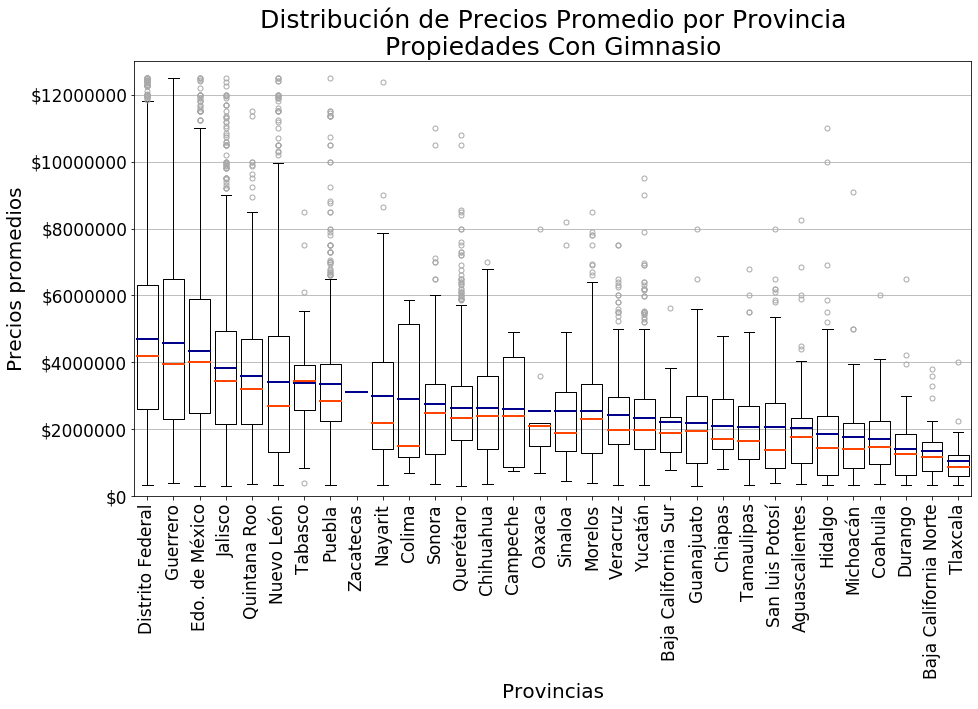

In [19]:
# Gráfico de distribución de precios de propiedades con gimnasio.
plt.figure(figsize = (15,8))
plt.ylim([0, 13000000])
plt.boxplot([
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][0]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][1]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][2]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][3]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][4]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][5]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][6]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][7]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][8]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][9]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][10]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][11]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][12]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][13]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][14]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][15]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][16]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][17]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][18]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][19]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][20]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][21]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][22]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][23]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][24]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][25]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][26]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][27]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][28]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][29]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][30]]['Precio'], \
    con_gimnasio.loc[con_gimnasio['Provincia'] == con_gimnasio_orden_media['Provincia'][31]]['Precio']], \
    labels = con_gimnasio_orden_media['Provincia'],             
    widths = 0.8,             
    meanline = True, showmeans = True,             
    boxprops = dict(linewidth=1),             
    meanprops = dict(linestyle = '-', linewidth=2, color = 'darkblue'),             
    # linestyle = '-' muestra la media con línea sólida
    showfliers = True,
    flierprops = dict(marker='o', markerfacecolor='none', markersize=5, linestyle='none', markeredgecolor = 'darkgrey'), \
    medianprops = dict(linestyle = '-', linewidth=2, color='orangered'))
plt.title('Distribución de Precios Promedio por Provincia\nPropiedades Con Gimnasio', fontsize = 25)
plt.ylabel('Precios promedios', fontsize = 20)
plt.xlabel('Provincias', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 17)
plt.yticks(fontsize = 17)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.gca().yaxis.grid(True)
plt.show()

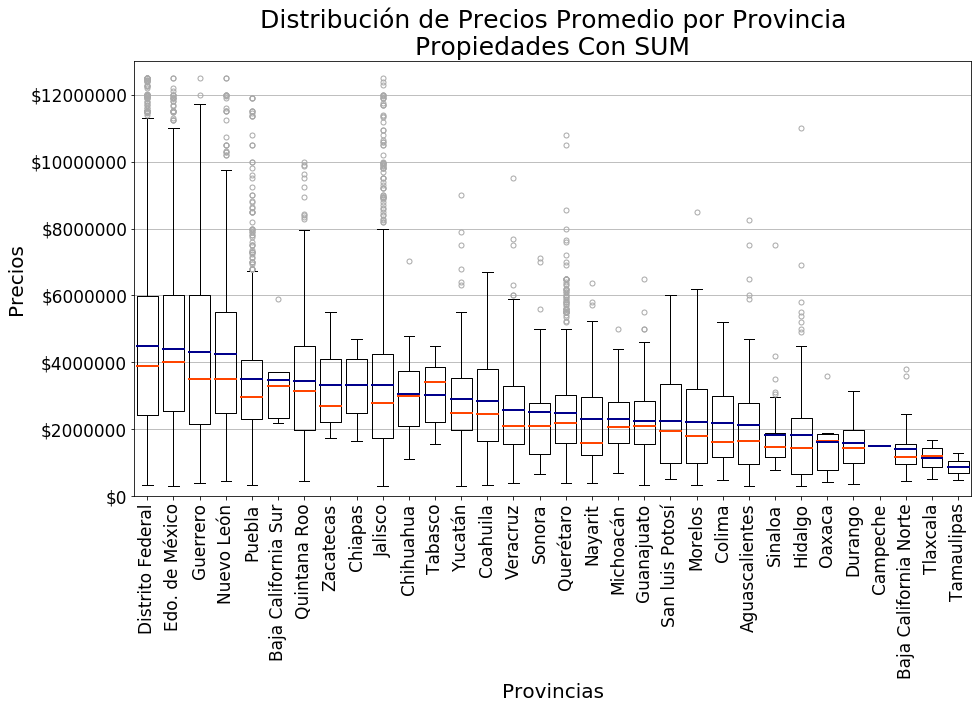

In [20]:
# Gráfico de distribución de precios de propiedades con salón de usos múltiples.
plt.figure(figsize = (15,8))
plt.ylim([0, 13000000])
plt.boxplot([
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][0]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][1]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][2]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][3]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][4]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][5]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][6]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][7]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][8]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][9]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][10]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][11]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][12]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][13]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][14]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][15]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][16]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][17]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][18]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][19]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][20]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][21]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][22]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][23]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][24]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][25]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][26]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][27]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][28]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][29]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][30]]['Precio'], \
    con_sum.loc[con_sum['Provincia'] == con_sum_orden_media['Provincia'][31]]['Precio']], \
    labels = con_sum_orden_media['Provincia'],             
    widths = 0.8,             
    meanline = True, showmeans = True,             
    boxprops = dict(linewidth=1),             
    meanprops = dict(linestyle = '-', linewidth=2, color = 'darkblue'),             
    # linestyle = '-' muestra la media con línea sólida
    showfliers = True,
    flierprops = dict(marker='o', markerfacecolor='none', markersize=5, linestyle='none', markeredgecolor = 'darkgrey'), \
    medianprops = dict(linestyle = '-', linewidth=2, color='orangered'))
plt.title('Distribución de Precios Promedio por Provincia\nPropiedades Con SUM', fontsize = 25)
plt.ylabel('Precios', fontsize = 20)
plt.xlabel('Provincias', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 17)
plt.yticks(fontsize = 17)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.gca().yaxis.grid(True)
plt.show()

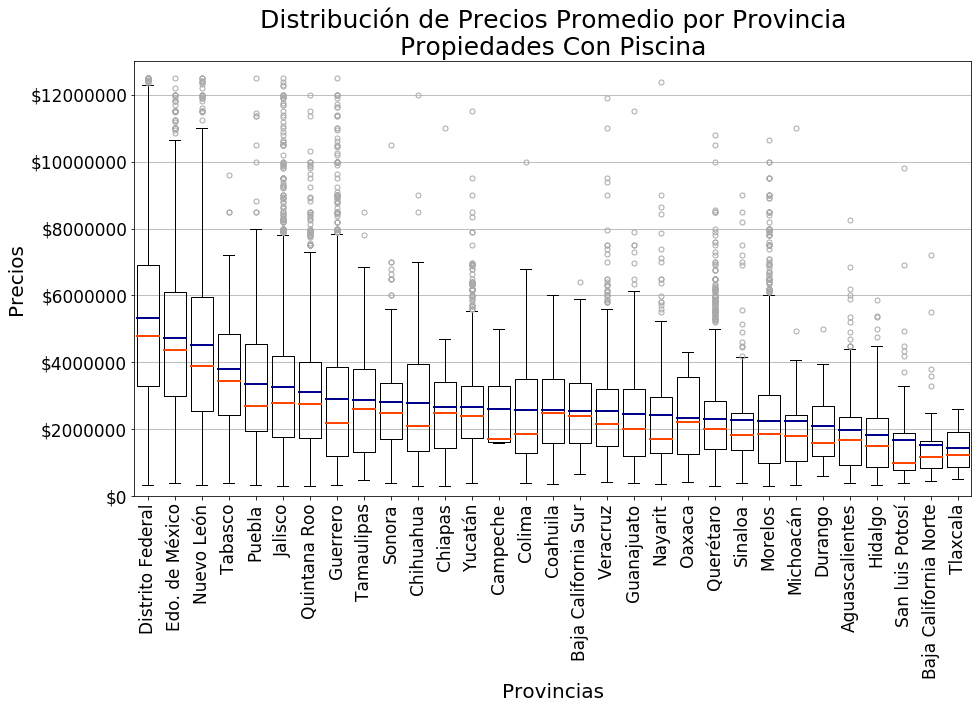

In [21]:
# Gráfico de distribución de precios de propiedades con salón de usos múltiples.
plt.figure(figsize = (15,8))
plt.ylim([0, 13000000])
plt.boxplot([
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][0]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][1]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][2]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][3]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][4]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][5]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][6]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][7]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][8]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][9]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][10]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][11]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][12]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][13]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][14]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][15]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][16]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][17]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][18]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][19]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][20]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][21]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][22]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][23]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][24]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][25]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][26]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][27]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][28]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][29]]['Precio'], \
    con_piscina.loc[con_piscina['Provincia'] == con_piscina_orden_media['Provincia'][30]]['Precio']], \
    labels = con_piscina_orden_media['Provincia'],
    widths = 0.8,             
    meanline = True, showmeans = True,             
    boxprops = dict(linewidth=1),             
    meanprops = dict(linestyle = '-', linewidth=2, color = 'darkblue'),             
    # linestyle = '-' muestra la media con línea sólida
    showfliers = True,
    flierprops = dict(marker='o', markerfacecolor='none', markersize=5, linestyle='none', markeredgecolor = 'darkgrey'),\
    medianprops = dict(linestyle = '-', linewidth=2, color='orangered'))
plt.title('Distribución de Precios Promedio por Provincia\nPropiedades Con Piscina', fontsize = 25)
plt.ylabel('Precios', fontsize = 20)
plt.xlabel('Provincias', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 17)
plt.yticks(fontsize = 17)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.gca().yaxis.grid(True)
plt.show()

Ahora se estudia la distribución de precios por provincia.

In [22]:
# Se crea la lista de provincias ordenadas por media de precios de propiedades.
df_abool_orden_media = df_abool.groupby('Provincia').agg({'Precio':'mean'})
df_abool_orden_media.rename(columns = {'Precio' : 'Media Precio'}, inplace=True)
df_abool_orden_media.sort_values(by='Media Precio', ascending = False, inplace = True)
df_abool_orden_media.reset_index(inplace = True)

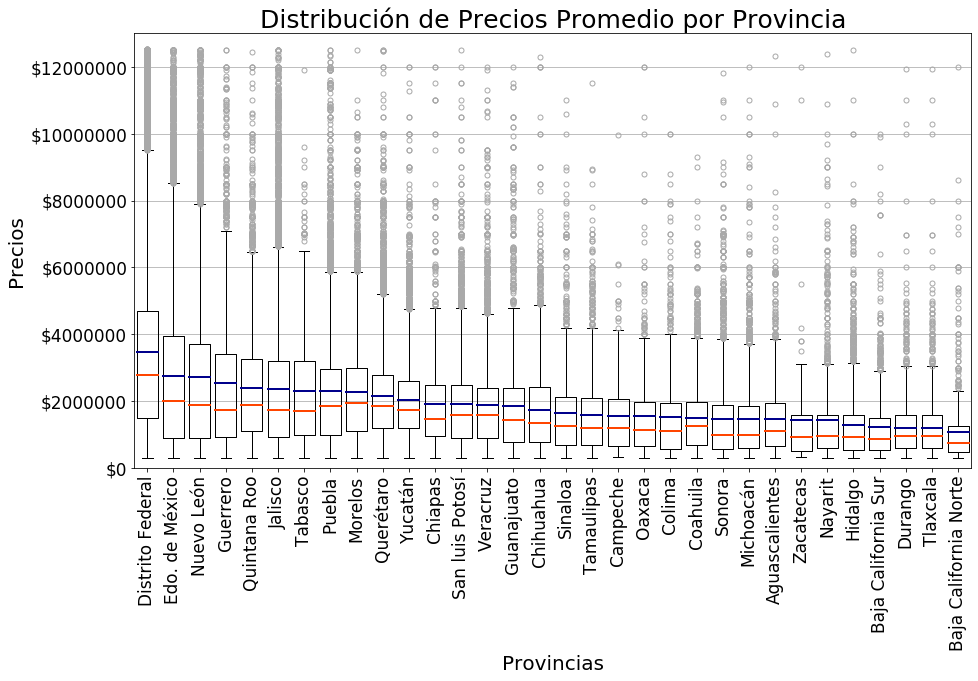

In [23]:
# Gráfico de distribución de precios de propiedades por provincia.
plt.figure(figsize = (15,8))
plt.ylim([0, 13000000])
plt.boxplot([
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][0]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][1]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][2]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][3]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][4]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][5]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][6]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][7]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][8]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][9]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][10]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][11]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][12]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][13]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][14]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][15]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][16]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][17]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][18]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][19]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][20]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][21]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][22]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][23]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][24]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][25]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][26]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][27]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][28]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][29]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][29]]['Precio'], \
    df_abool.loc[df_abool['Provincia'] == df_abool_orden_media['Provincia'][30]]['Precio']], \
    labels = df_abool_orden_media['Provincia'],             
    widths = 0.8,             
    meanline = True, showmeans = True,             
    boxprops = dict(linewidth=1),             
    meanprops = dict(linestyle = '-', linewidth=2, color = 'darkblue'),             
    # linestyle = '-' muestra la media con línea sólida
    showfliers = True,
    flierprops = dict(marker='o', markerfacecolor='none', markersize=5, linestyle='none', markeredgecolor = 'darkgrey'), \
    medianprops = dict(linestyle = '-', linewidth=2, color='orangered'))
plt.title('Distribución de Precios Promedio por Provincia', fontsize = 25)
plt.ylabel('Precios', fontsize = 20)
plt.xlabel('Provincias', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 17)
plt.yticks(fontsize = 17)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.gca().yaxis.grid(True)
plt.show()

Todas las medianas están por debajo de las medias.

Luego se busca la provincia que más registro de comodidades tiene, para ver si se comporta de la misma manera.

In [24]:
# Se agrupa por provincias y se suman las comodidades por tipo.
cant_registros_provincia = \
    df_abool\
        .groupby('Provincia')\
        .agg({'TieneGimnasio':'sum', \
              'TieneUsosMultiples':'sum', \
              'TienePileta':'sum', \
              'TieneEscuelasCerca':'sum', \
              'TieneShoppingsCerca':'sum'})
# Se agrega una columna que suma el total de las comodidades por provincia.
cant_registros_provincia['Total'] = cant_registros_provincia.sum(axis = 1)
# Se ordena de forma descendente por total de comodidades por provincia.
cant_registros_provincia.sort_values(by = 'Total', ascending = False, inplace = True)
# Se ubica la provincia con más comodidades registradas.
cant_registros_provincia.iloc[0].to_frame().T

,TieneGimnasio,TieneUsosMultiples,TienePileta,TieneEscuelasCerca,TieneShoppingsCerca,Total
Distrito Federal,4410.0,4044.0,2627.0,28118.0,26185.0,65384.0


In [25]:
# Otra forma de encontrar la provincia con más comodidades (sin ordenar).
cant_registros_provincia\
    .loc[cant_registros_provincia['Total'] == cant_registros_provincia['Total'].max()]

,TieneGimnasio,TieneUsosMultiples,TienePileta,TieneEscuelasCerca,TieneShoppingsCerca,Total
Provincia,,,,,,
Distrito Federal,4410.0,4044.0,2627.0,28118.0,26185.0,65384.0


La provincia con más comodidades anotadas es Distrito Federal.

In [26]:
# Se crea un DataFrame para tener un orden por promedio de precios en ciudades de Distrito Federal.
distrito_federal = df_abool.loc[df_abool['Provincia'] == 'Distrito Federal'].copy()
# Se agrupa por ciudades, se se calcula la media y se ordena de manera descendente.
distrito_federal_ciudades_orden_media = \
    distrito_federal\
        .groupby('Ciudad')\
        .agg({'Precio':'mean'})\
        .sort_values(by = 'Precio', ascending = False)
# Se renombra la columna
distrito_federal_ciudades_orden_media.columns = ['Media Precio']
# Se resetea el índice para tener la columna Ciudad.
distrito_federal_ciudades_orden_media.reset_index(inplace = True)

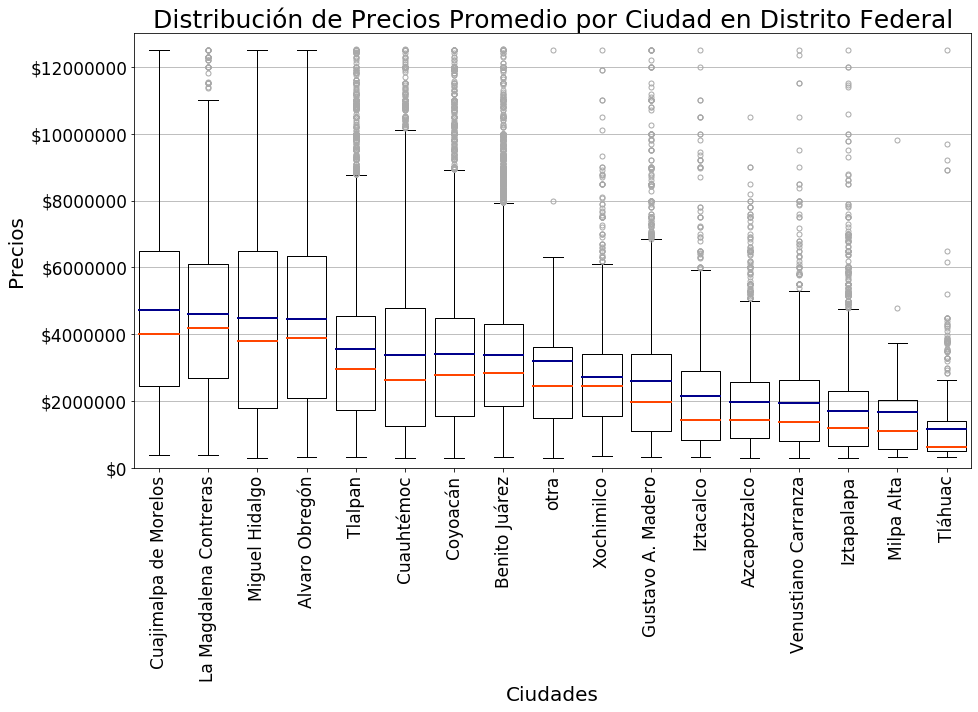

In [27]:
# Gráfico de distribución de precios de propiedades en Distrito Federal, por ciudad.
plt.figure(figsize = (15,8))
plt.ylim([0, 13000000])
plt.boxplot([
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][0]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][1]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][2]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][3]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][4]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][5]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][6]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][7]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][8]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][9]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][10]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][11]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][12]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][13]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][14]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][15]]['Precio'], \
    df_abool.loc[df_abool['Ciudad'] == distrito_federal_ciudades_orden_media['Ciudad'][16]]['Precio']], \
    labels = distrito_federal_ciudades_orden_media['Ciudad'],             
    widths = 0.8,             
    meanline = True, showmeans = True,             
    boxprops = dict(linewidth=1),             
    meanprops = dict(linestyle = '-', linewidth=2, color = 'darkblue'),             
    # linestyle = '-' muestra la media con línea sólida
    showfliers = True,
    flierprops = dict(marker='o', markerfacecolor='none', markersize=5, linestyle='none', markeredgecolor = 'darkgrey'), \
    medianprops = dict(linestyle = '-', linewidth=2, color='orangered'))
plt.title('Distribución de Precios Promedio por Ciudad en Distrito Federal', fontsize = 25)
plt.ylabel('Precios', fontsize = 20)
plt.xlabel('Ciudades', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 17)
plt.yticks(fontsize = 17)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.gca().yaxis.grid(True)
plt.show()

También tiene las medianas por debajo de las medias.

Por otra parte, se puede ver cuáles son las coincidencias para las 10 provincias más caras y las 10 más baratas. Se usa una unión para hallar las mismas.

In [28]:
inicio = 0
fin = 10
coincidencias_caras = pd.merge(df_abool_orden_media[inicio:fin], con_sum_orden_media[inicio:fin], on = ['Provincia'], how = 'inner')
coincidencias_caras = pd.merge(coincidencias_caras, con_piscina_orden_media[inicio:fin], on = ['Provincia'], how = 'inner')
coincidencias_caras = pd.merge(coincidencias_caras, con_gimnasio_orden_media[inicio:fin], on = ['Provincia'], how = 'inner')
coincidencias_caras['Provincia'].to_frame().T

,0,1,2,3,4,5,6
Provincia,Distrito Federal,Edo. de México,Nuevo León,Guerrero,Quintana Roo,Jalisco,Puebla


In [29]:
inicio = 20
fin = 32
coincidencias_baratas = pd.merge(df_abool_orden_media[inicio:fin], con_sum_orden_media[inicio:fin], on = ['Provincia'], how = 'inner')
coincidencias_baratas = pd.merge(coincidencias_baratas, con_piscina_orden_media[inicio:fin], on = ['Provincia'], how = 'inner')
coincidencias_baratas = pd.merge(coincidencias_baratas, con_gimnasio_orden_media[inicio:fin], on = ['Provincia'], how = 'inner')
coincidencias_baratas['Provincia'].to_frame().T

,0,1,2,3,4
Provincia,Aguascalientes,Hidalgo,Durango,Tlaxcala,Baja California Norte


# Análisis de tipo de comodidad a medida que pasan los años

In [30]:
# Se usa df_ok para las columnas porque tiene números en las columnas, sirve para contar.
df_comodidad = dfok[['Antiguedad', \
                     'TieneGimnasio', \
                     'TieneUsosMultiples', \
                     'TienePileta', \
                     'TieneEscuelasCerca', \
                     'TieneShoppingsCerca']].copy() # Para modificar df_comodidad sin warnings.

Se analiza si hay casos nulos.

In [31]:
print('Casos nulos por columna:')
print(df_comodidad.isnull().sum())
print('\nTipo de dato de las columnas:')
print(df_comodidad.dtypes)
memoria_usada = df_comodidad.memory_usage().sum()/(1024*1024)
print('\nMemoria usada', memoria_usada.round(2), "MB")

Casos nulos por columna:
Antiguedad             43555
TieneGimnasio              0
TieneUsosMultiples         0
TienePileta                0
TieneEscuelasCerca         0
TieneShoppingsCerca        0
dtype: int64

Tipo de dato de las columnas:
Antiguedad             float64
TieneGimnasio          float64
TieneUsosMultiples     float64
TienePileta            float64
TieneEscuelasCerca     float64
TieneShoppingsCerca    float64
dtype: object

Memoria usada 10.99 MB


Hay 43555 casos nulos y es necesario rmoverlos para covertir los tipos. Hasta aquí los tipos del DataFrame `df_comodidad` son `float64`.

In [32]:
# Se eliminan las filas nulas, para así poder realizar las conversión de tipos.
# Además, para este análisis es necesario un valor en la columna 'Antiguedad'.
df_comodidad.dropna(inplace = True)

In [33]:
df_comodidad.head()

,Antiguedad,TieneGimnasio,TieneUsosMultiples,TienePileta,TieneEscuelasCerca,TieneShoppingsCerca
1,10.0,0.0,0.0,0.0,1.0,1.0
2,5.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,1.0
4,10.0,0.0,0.0,0.0,0.0,0.0
5,5.0,0.0,0.0,0.0,0.0,1.0


In [34]:
# Se cambian los tipos del DataFrame.
df_comodidad['Antiguedad'] = df_comodidad['Antiguedad'].astype(np.uint8)
df_comodidad['TieneGimnasio'] = df_comodidad['TieneGimnasio'].astype(np.uint8)
df_comodidad['TieneUsosMultiples'] = df_comodidad['TieneUsosMultiples'].astype(np.uint8)
df_comodidad['TienePileta'] = df_comodidad['TienePileta'].astype(np.uint8)
df_comodidad['TieneEscuelasCerca'] = df_comodidad['TieneEscuelasCerca'].astype(np.uint8)
df_comodidad['TieneShoppingsCerca'] = df_comodidad['TieneShoppingsCerca'].astype(np.uint8)
memoria_usada = df_comodidad.memory_usage().sum()/(1024*1024)
print('Memoria usada', memoria_usada.round(2), "MB")

Memoria usada 2.62 MB


Como se tienen 80 años para antigüedad, agregro una columna con rango de años tomados de a 5 años(lustros).

Para esto se define una función de calcula el rango de años dónde cae la antigüedad de la propiedad. Primero se elige un orden y luego se cambia el nombre de las filas. De esta manera se evita tener que insertar una fila en medio del DataFrame: 
 - el rango `6 - 10` quedaría entre `56 - 60` y `61 - 65`.

In [35]:
# Se define una función de calcula el rango de años dónde cae la antigüedad de la propiedad.
# Primero se elige un orden y luego se cambia el nombre de las filas.
# Esto es para evitar tener que insertar una fila en medio del DataFrame.
def rango_de_años(df):
    if df['Antiguedad'] <= 5: return '00'# '0 - 5'
    elif 6  <= df['Antiguedad'] <= 10: return '01'# '6 - 10'
    elif 11 <= df['Antiguedad'] <= 15: return '02'# '11 - 15'
    elif 16 <= df['Antiguedad'] <= 20: return '03'# '16 - 20'
    elif 21 <= df['Antiguedad'] <= 25: return '04'# '21 - 25'
    elif 26 <= df['Antiguedad'] <= 30: return '05'# '26 - 30'
    elif 31 <= df['Antiguedad'] <= 35: return '06'# '31 - 35'
    elif 36 <= df['Antiguedad'] <= 40: return '07'# '26 - 40'
    elif 41 <= df['Antiguedad'] <= 45: return '08'# '41 - 45'
    elif 46 <= df['Antiguedad'] <= 50: return '09'# '46 - 50'
    elif 51 <= df['Antiguedad'] <= 55: return '10'# '51 - 55'
    elif 56 <= df['Antiguedad'] <= 60: return '11'# '56 - 60'
    elif 61 <= df['Antiguedad'] <= 65: return '12'# '61 - 65'
    elif 66 <= df['Antiguedad'] <= 70: return '13'# '66 - 70'
    elif 71 <= df['Antiguedad'] <= 75: return '14'# '71 - 75'
    elif 76 <= df['Antiguedad'] <= 80: return '15'# '76 - 80'

In [36]:
# Auxiliar para asignar lustros.
aux = df_comodidad.apply(rango_de_años, axis = 1) # Devuelve una Serie

In [37]:
# Se hace una copia para los agrupados y se agrega la columna LustroAntiguedad.
df_comodidad_lustros = df_comodidad.copy()
df_comodidad_lustros['LustrosAntiguedad'] = aux

In [38]:
# Se agrupa por LustroAntiguedad y se suman los unos.
# Se termina descartando la columna Antiguedad en df_comodidad_lustro.
df_comodidad_lustros = \
    df_comodidad_lustros.\
        groupby('LustrosAntiguedad')\
        .agg({'TieneGimnasio':'sum', \
              'TieneUsosMultiples':'sum', \
              'TienePileta':'sum', \
              'TieneEscuelasCerca':'sum', \
              'TieneShoppingsCerca':'sum'})
# Cambio del tipo de datos.
df_comodidad_lustros['TieneGimnasio'] = df_comodidad_lustros['TieneGimnasio'].astype(np.uint16)
df_comodidad_lustros['TieneUsosMultiples'] = df_comodidad_lustros['TieneUsosMultiples'].astype(np.uint16)
df_comodidad_lustros['TienePileta'] = df_comodidad_lustros['TienePileta'].astype(np.uint16)
df_comodidad_lustros['TieneEscuelasCerca'] = df_comodidad_lustros['TieneEscuelasCerca'].astype(np.uint16)
df_comodidad_lustros['TieneShoppingsCerca'] = df_comodidad_lustros['TieneShoppingsCerca'].astype(np.uint16)
# Se reseta el índice
df_comodidad_lustros.reset_index(inplace = True)
# Se renombra la columna LustrosAntiguedad.
df_comodidad_lustros['LustrosAntiguedad'] = \
['0 - 5', '6 - 10', '11 - 15', '16 - 20', \
 '21 - 25', '26 - 30', '31 - 35', '36 - 40', \
 '41 - 45', '46 - 50', '51 - 55', '56 - 60', \
 '61 - 65', '66 - 70', '71 - 75', '76 - 80']
# Se elige como índice la columna LustrosAntiguedad con los nuevos nombres.
df_comodidad_lustros.set_index('LustrosAntiguedad', inplace = True)

In [39]:
df_comodidad_lustros

,TieneGimnasio,TieneUsosMultiples,TienePileta,TieneEscuelasCerca,TieneShoppingsCerca
LustrosAntiguedad,,,,,
0 - 5,10782,9652,15573,58159,52386
6 - 10,1659,1498,2236,20149,18271
11 - 15,314,218,457,3610,2841
16 - 20,544,671,697,12406,11514
21 - 25,162,78,138,1758,1343
26 - 30,62,85,105,1834,1494
31 - 35,15,37,31,652,493
36 - 40,14,19,28,680,527
41 - 45,1,5,4,187,140


In [40]:
# Se calcula la totalidad de comodidades registradas.
total_comodidad_lustros = df_comodidad_lustros.sum(axis = 1)
# Se calculan las porporciones por lustro.
df_comodidad_propor_lustros = df_comodidad_lustros.apply(lambda x : round(x/total_comodidad_lustros,3))
# Se renombran las columnas apropiadamente.
columnas_proporciones = ['Proporcion Gimnasio', \
                         'Proporcion UsosMultiples', \
                         'Proporcion Pileta', \
                         'Proporcion EscuelasCerca', \
                         'Proporcion ShoppingsCerca']
df_comodidad_propor_lustros.columns = columnas_proporciones

In [41]:
# Se agregan las columnas de amenidades propias (gimnasio, SUM y piscina) y compartidas (escuelas y shoppings cercanos).
df_comodidad_propor_lustros['Proporcion Propias'] = \
        df_comodidad_propor_lustros['Proporcion Gimnasio'] + \
        df_comodidad_propor_lustros['Proporcion UsosMultiples'] + \
        df_comodidad_propor_lustros['Proporcion Pileta']
df_comodidad_propor_lustros['Proporcion Compartidas'] = \
        df_comodidad_propor_lustros['Proporcion EscuelasCerca'] + \
        df_comodidad_propor_lustros['Proporcion ShoppingsCerca']

In [42]:
df_comodidad_propor_lustros

,Proporcion Gimnasio,Proporcion UsosMultiples,Proporcion Pileta,Proporcion EscuelasCerca,Proporcion ShoppingsCerca,Proporcion Propias,Proporcion Compartidas
LustrosAntiguedad,,,,,,,
0 - 5,0.074,0.066,0.106,0.397,0.357,0.246,0.754
6 - 10,0.038,0.034,0.051,0.460,0.417,0.123,0.877
11 - 15,0.042,0.029,0.061,0.485,0.382,0.132,0.867
16 - 20,0.021,0.026,0.027,0.480,0.446,0.074,0.926
21 - 25,0.047,0.022,0.040,0.505,0.386,0.109,0.891
26 - 30,0.017,0.024,0.029,0.512,0.417,0.070,0.929
31 - 35,0.012,0.030,0.025,0.531,0.401,0.067,0.932
36 - 40,0.011,0.015,0.022,0.536,0.416,0.048,0.952
41 - 45,0.003,0.015,0.012,0.555,0.415,0.030,0.970


In [43]:
print(df_comodidad_propor_lustros.mean().round(2))

Proporcion Gimnasio          0.03
Proporcion UsosMultiples     0.02
Proporcion Pileta            0.03
Proporcion EscuelasCerca     0.51
Proporcion ShoppingsCerca    0.41
Proporcion Propias           0.08
Proporcion Compartidas       0.92
dtype: float64


La media de la proporción de amenidades compartidas supera por más del 90% del total a las propias. Por esto se realizan una análisis separado.
 
También se puede calcular la proporción de registros que le corresponde a cada lustro. Para eso se puede usar la Serie `total_comodidades`, que contiene la cantidad total de amenidades registradas en cada lustro. Si se suma lo acumulado por cada lustro en los 80 años se obtiene la cantidad total de amenidades.

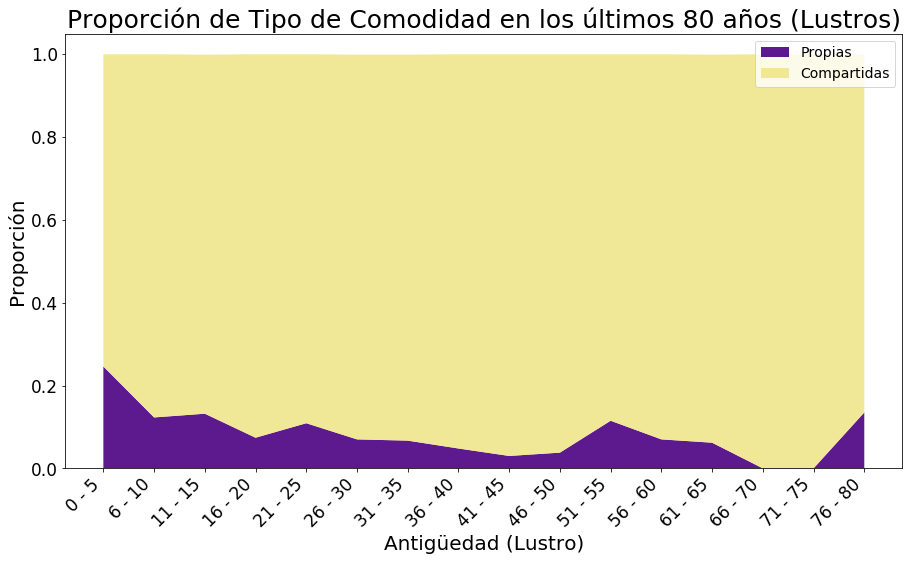

In [44]:
plt.figure(figsize=(15,8))
x = df_comodidad_propor_lustros.index
y = [df_comodidad_propor_lustros['Proporcion Propias'], \
     df_comodidad_propor_lustros['Proporcion Compartidas']
    ]
plt.stackplot(x,y, \
              labels = ['Propias', 'Compartidas'], \
              colors = ['indigo', 'khaki'], \
              alpha = 0.9)
plt.title('Proporción de Tipo de Comodidad en los últimos 80 años (Lustros)', fontsize = 25)
plt.xticks(fontsize = 17, rotation = 45, ha = 'right')
plt.yticks(fontsize = 17)
plt.xlabel('Antigüedad (Lustro)', fontsize = 20)
plt.ylabel('Proporción', fontsize = 20)
plt.legend(loc='upper right', fontsize = 14)
plt.show()

Aquí se visualiza la proporción de comodidades a los largo de los años por lustros. Se nota una clara dominancia de las amenidades compartidas por sobre las propia.

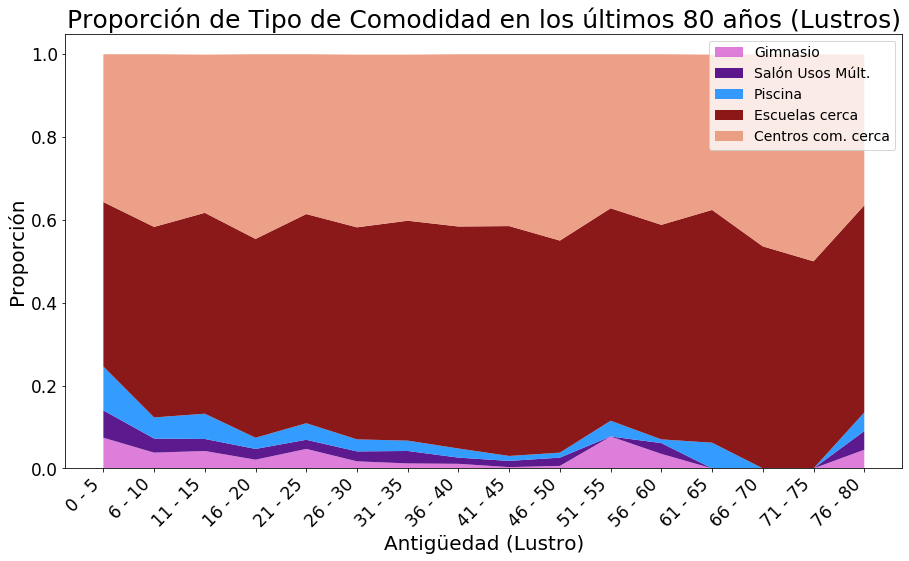

In [45]:
plt.figure(figsize=(15,8))
x = df_comodidad_propor_lustros.index
y = [df_comodidad_propor_lustros['Proporcion Gimnasio'], \
     df_comodidad_propor_lustros['Proporcion UsosMultiples'], \
     df_comodidad_propor_lustros['Proporcion Pileta'], \
     df_comodidad_propor_lustros['Proporcion EscuelasCerca'], \
     df_comodidad_propor_lustros['Proporcion ShoppingsCerca']
    ]
plt.stackplot(x,y, \
              labels = ['Gimnasio', \
                        'Salón Usos Múlt.', \
                        'Piscina', \
                        'Escuelas cerca', \
                        'Centros com. cerca'], \
              colors = ['orchid', 'indigo', 'dodgerblue', 'maroon', 'darksalmon'], \
              alpha = 0.9)
plt.title('Proporción de Tipo de Comodidad en los últimos 80 años (Lustros)', fontsize = 25)
plt.xticks(fontsize = 17, rotation = 45, ha = 'right')
plt.yticks(fontsize = 17)
plt.xlabel('Antigüedad (Lustro)', fontsize = 20)
plt.ylabel('Proporción', fontsize = 20)
plt.legend(loc='upper right', fontsize = 14)
plt.show()

Lo anterior muestra la proporción a cada tipo particular de comodidades.
 
A continuación se analiza la evolución de los registros de amenidades en años.

In [46]:
# Se agrupa por Antiguedad y se suman los unos.
df_comodidad_anios = \
    df_comodidad\
        .groupby('Antiguedad')\
        .agg({'TieneGimnasio':'sum', \
              'TieneUsosMultiples':'sum', \
              'TienePileta':'sum', \
              'TieneEscuelasCerca':'sum', \
              'TieneShoppingsCerca':'sum'})

In [47]:
# Se calcula la totalidad de comodidades registradas por año.
total_comodidad_anios = df_comodidad_anios.sum(axis=1)
# Se calculan las porporciones por año.
df_comodidad_propor_anios = df_comodidad_anios.apply(lambda x : round(x/total_comodidad_anios, 3))
# Se renombran las columnas apropiadamente, con los mismos nombres de antes: columnas_proporciones.
df_comodidad_propor_anios.columns = columnas_proporciones

In [48]:
df_comodidad_propor_anios.loc[df_comodidad_propor_anios['Proporcion EscuelasCerca'].isnull() == True]

,Proporcion Gimnasio,Proporcion UsosMultiples,Proporcion Pileta,Proporcion EscuelasCerca,Proporcion ShoppingsCerca
Antiguedad,,,,,
64,NaN,NaN,NaN,NaN,NaN
71,NaN,NaN,NaN,NaN,NaN
74,NaN,NaN,NaN,NaN,NaN
76,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN


Hay años en los que hay datos nulos. Esto puede ser porque no hubo registros de esos años.

In [49]:
# Se reemplaza los datos nulos con ceros.
df_comodidad_propor_anios.fillna(0, inplace = True)
df_comodidad_propor_anios.loc[df_comodidad_propor_anios.sum(axis = 1) == 0]

,Proporcion Gimnasio,Proporcion UsosMultiples,Proporcion Pileta,Proporcion EscuelasCerca,Proporcion ShoppingsCerca
Antiguedad,,,,,
64,0.0,0.0,0.0,0.0,0.0
71,0.0,0.0,0.0,0.0,0.0
74,0.0,0.0,0.0,0.0,0.0
76,0.0,0.0,0.0,0.0,0.0
79,0.0,0.0,0.0,0.0,0.0


Los años de antigüedad 64, 71, 74, 76 y 79 no registran tipos de comodidades.

In [50]:
# Se verifica si hay años faltantes para el atributo antigüedad.
antiguedades = dfok['Antiguedad'].value_counts() # Es una Serie.
print('Cantidad de años que informan registro de antigüedad:', len(antiguedades))
# Se busca obtener la columna Antiguedad.
antiguedades = antiguedades.to_frame()
antiguedades.reset_index(inplace = True)
antiguedades.columns = ['Antiguedad', 'Cantidad']
# Se ordenan de menor a mayor los años de antigüedad.
antiguedades.sort_values(by = 'Antiguedad', ascending = True, inplace = True)
antiguedades.set_index('Antiguedad', inplace = True)
# Se muestran los últimos casos.
print(antiguedades[71:80].index)

Cantidad de años que informan registro de antigüedad: 78
Float64Index([71.0, 74.0, 75.0, 76.0, 77.0, 79.0, 80.0], dtype='float64', name='Antiguedad')


Faltan los años de antigüedad 72, 73 y 78.
 
Entonces se tienen los siguientes años sin registro de comodidades:
        64 - 71 - 72 - 73 - 74 - 76 - 78 - 79

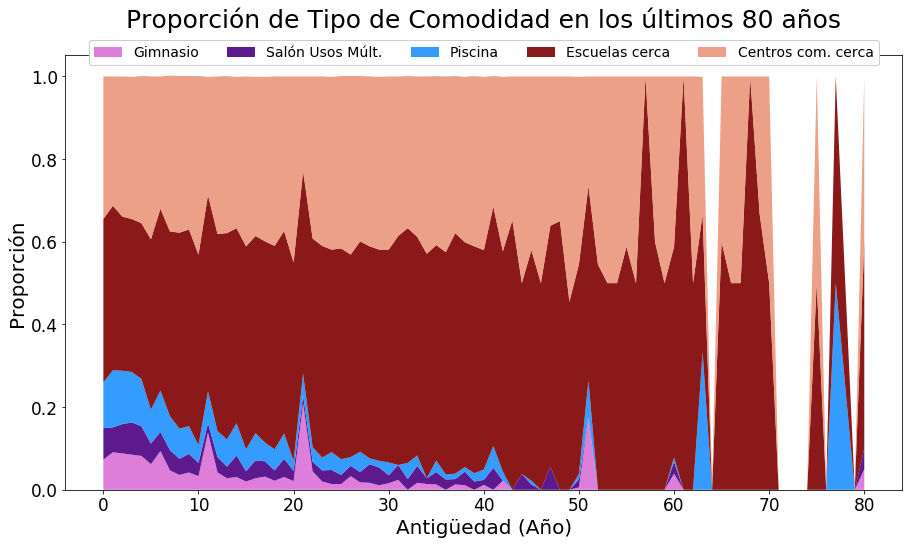

In [51]:
plt.figure(figsize=(15,8))
x = df_comodidad_propor_anios.index
y = [df_comodidad_propor_anios['Proporcion Gimnasio'], \
     df_comodidad_propor_anios['Proporcion UsosMultiples'], \
     df_comodidad_propor_anios['Proporcion Pileta'], \
     df_comodidad_propor_anios['Proporcion EscuelasCerca'], \
     df_comodidad_propor_anios['Proporcion ShoppingsCerca']
    ]
plt.stackplot(x,y, \
              labels = ['Gimnasio', 'Salón Usos Múlt.', 'Piscina', 'Escuelas cerca', 'Centros com. cerca'], \
              colors = ['orchid', 'indigo', 'dodgerblue', 'maroon', 'darksalmon'], \
              alpha = 0.9)
plt.title('Proporción de Tipo de Comodidad en los últimos 80 años', fontsize = 25, y = 1.05)
plt.xticks(fontsize = 17, rotation = 0, ha = 'center')
plt.yticks(fontsize = 17)
plt.xlabel('Antigüedad (Año)', fontsize = 20)
plt.ylabel('Proporción', fontsize = 20)
plt.legend(loc = 'upper center', fontsize = 14, bbox_to_anchor = (0.5, 1.05), ncol = 5, framealpha = 1)
plt.show()

Se puede puede ver cómo queda la proporción para los años que sí anotaron comodididades.

In [52]:
# Se remueven los años en los que no se registró ninguna comodidad.
df_comodidad_propor_anios_limpio = \
    df_comodidad_anios\
        .loc[df_comodidad_anios.sum(axis = 1) != 0.0]\
        .copy()
# Se guarda una Serie con los valores totales por año.
total_comodidad_anios_limpios = df_comodidad_propor_anios_limpio.sum(axis = 1)
# Se renombran las columnas de manera apropiada.
df_comodidad_propor_anios_limpio.columns = columnas_proporciones
# Se calculan las proporciones de los tipos de comodidad por año.
df_comodidad_propor_anios_limpio = \
    df_comodidad_propor_anios_limpio\
        .apply(lambda x : round(x/total_comodidad_anios_limpios, 3))

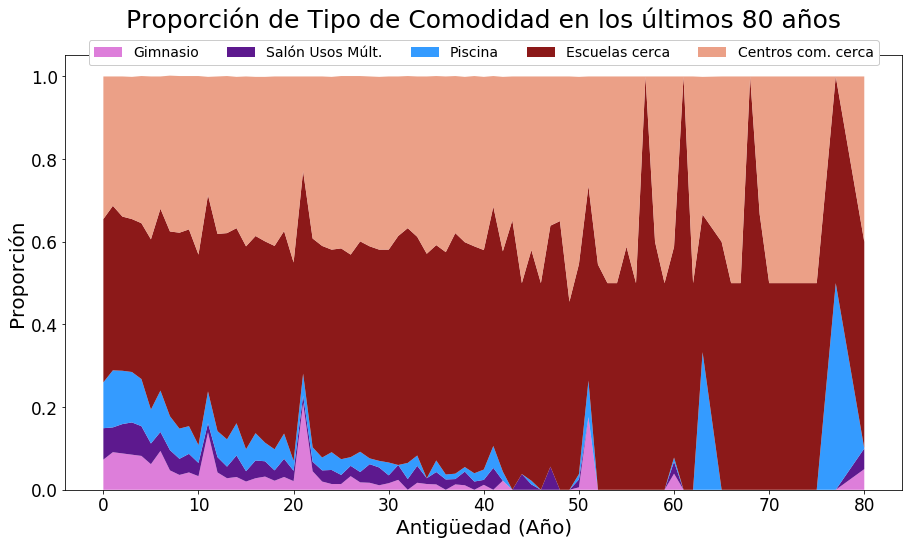

In [53]:
plt.figure(figsize=(15,8))
x = df_comodidad_propor_anios_limpio.index
y = [df_comodidad_propor_anios_limpio['Proporcion Gimnasio'], \
     df_comodidad_propor_anios_limpio['Proporcion UsosMultiples'], \
     df_comodidad_propor_anios_limpio['Proporcion Pileta'], \
     df_comodidad_propor_anios_limpio['Proporcion EscuelasCerca'], \
     df_comodidad_propor_anios_limpio['Proporcion ShoppingsCerca']
    ]
plt.stackplot(x,y, \
              labels = ['Gimnasio', 'Salón Usos Múlt.', 'Piscina', 'Escuelas cerca', 'Centros com. cerca'], \
              colors = ['orchid', 'indigo', 'dodgerblue', 'maroon', 'darksalmon'], \
              alpha = 0.9)
plt.title('Proporción de Tipo de Comodidad en los últimos 80 años', fontsize = 25, y = 1.05)
plt.xticks(fontsize = 17, rotation = 0, ha = 'center')
plt.yticks(fontsize = 17)
plt.xlabel('Antigüedad (Año)', fontsize = 20)
plt.ylabel('Proporción', fontsize = 20)
plt.legend(loc = 'upper center', fontsize = 14, bbox_to_anchor = (0.5, 1.05), ncol = 5, framealpha = 1)
plt.show()

Se puede analizar en qué período se acumula la cantidad de registros de amenidades.

In [54]:
# Se crea columna con la suma de amenidades por año.
df_comodidad_anios['Total'] = total_comodidad_anios
# Se resetea el índice para tener una columna Antiguedad.
df_comodidad_anios.reset_index(inplace = True)

In [55]:
# Se calcula la proporción de comodidades registradas según rango de antigüedad.
print('Proporción de comodidades con antigüedad de hasta 5 años:', \
      round(total_comodidad_anios[0:6].sum()/total_comodidad_anios.sum()*100, 2), '%')
print('Proporción de comodidades con antigüedad de hasta 10 años:', \
      round(total_comodidad_anios[0:11].sum()/total_comodidad_anios.sum()*100, 2), '%')
print('Proporción de comodidades con antigüedad de hasta 20 años:', \
      round(total_comodidad_anios[0:21].sum()/total_comodidad_anios.sum()*100, 2), '%')
print('Proporción de comodidades con antigüedad de hasta 30 años:', \
      round(total_comodidad_anios[0:31].sum()/total_comodidad_anios.sum()*100, 2), '%')
print('Proporción de comodidades con antigüedad de hasta 38 años:', \
      round(total_comodidad_anios[0:39].sum()/total_comodidad_anios.sum()*100, 2), '%')
print('Proporción de comodidades con antigüedad de hasta 40 años:', \
      round(total_comodidad_anios[0:41].sum()/total_comodidad_anios.sum()*100, 2), '%')
print('Cantidad de años que registran comodidades:', len(df_comodidad_anios))

Proporción de comodidades con antigüedad de hasta 5 años: 62.36 %
Proporción de comodidades con antigüedad de hasta 10 años: 81.0 %
Proporción de comodidades con antigüedad de hasta 20 años: 95.16 %
Proporción de comodidades con antigüedad de hasta 30 años: 98.16 %
Proporción de comodidades con antigüedad de hasta 38 años: 98.79 %
Proporción de comodidades con antigüedad de hasta 40 años: 99.22 %
Cantidad de años que registran comodidades: 78


Más del 98% de las comodidades se registraron en propiedades de hasta 38 años de antigüedad. 78/2 = 39 entonces, de 0 a 38 años se tiene la mitad de los años que informan anotaciones y en ese rango se condensa la mayoría de registros de amenidades. 

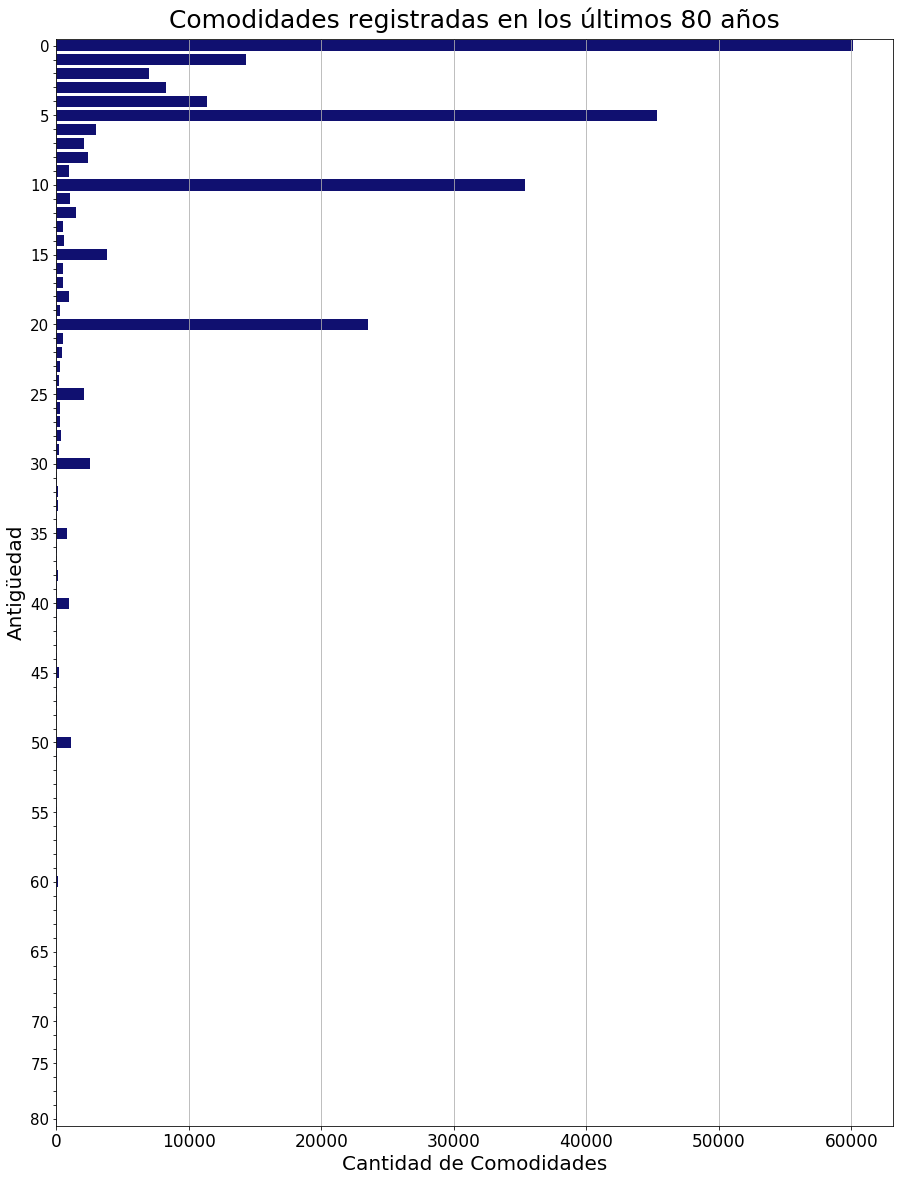

In [56]:
plt.figure(figsize = (15,20))
plot = sb.barplot(x = 'Total', y = 'Antiguedad', data = df_comodidad_anios[0:78], color = 'navy', orient = 'h')
plt.title('Comodidades registradas en los últimos 80 años', fontsize = 25, y = 1.005)
plt.xticks(fontsize = 17, rotation = 0, ha = 'center')
plt.yticks(fontsize = 15)
plt.ylabel('Antigüedad', fontsize = 20)
plt.xlabel('Cantidad de Comodidades', fontsize = 20)
plt.gca().xaxis.grid(True)

for label in plot.get_yticklabels():
    if np.int(label.get_text()) % 5 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
        
plt.show()

Las cantidades de los casos más antiguas son tan pequeñas que frente a los numeros casos nuevos no se perciben. Si se toman los últimos 49 años se tiene lo siguiente.

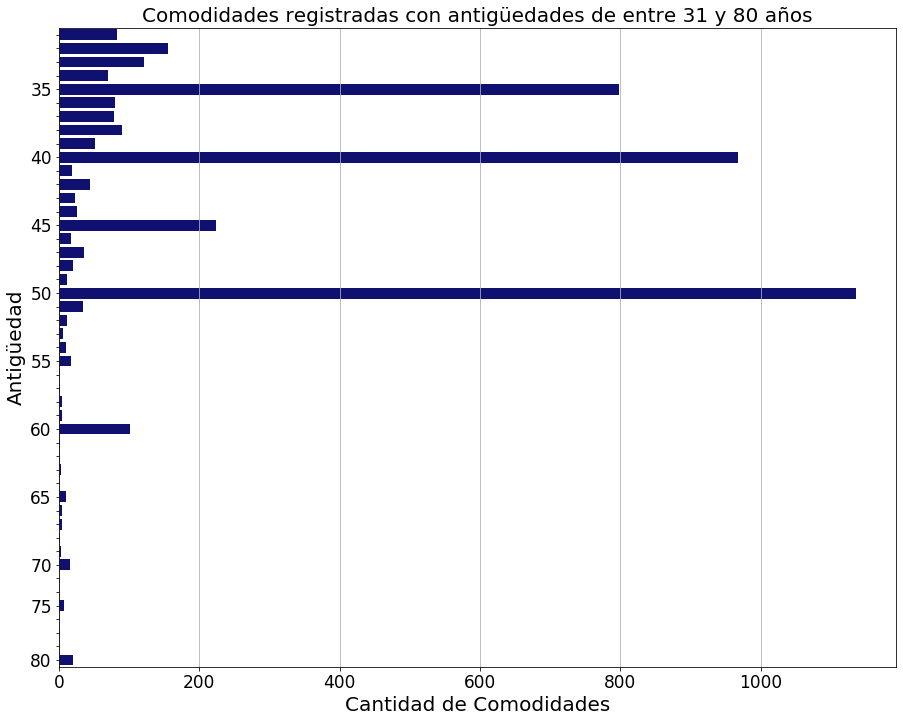

In [57]:
plt.figure(figsize = (15,11.75))
plot = sb.barplot(x = 'Total', y = 'Antiguedad', data = df_comodidad_anios[31:78], color = 'navy', orient = 'h')
plt.title('Comodidades registradas con antigüedades de entre 31 y 80 años', fontsize = 20)
plt.xticks(fontsize = 17, rotation = 0, ha = 'center')
plt.yticks(fontsize = 17)
plt.ylabel('Antigüedad', fontsize = 20)
plt.xlabel('Cantidad de Comodidades', fontsize = 20)
plt.gca().xaxis.grid(True)

for label in plot.get_yticklabels():
    if np.int(label.get_text()) % 5 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
        
plt.show()

En los años que son múltiplos de 5 se tiene picos de cantidad de anotaciones

In [58]:
# Se crean DataFrames para diferenciar amenidades propias y compartidas.
df_comodidad_anios_propias = df_comodidad_anios[['Antiguedad', 'TieneGimnasio', 'TieneUsosMultiples', 'TienePileta']].copy()
df_comodidad_anios_propias.set_index('Antiguedad', inplace = True)
df_comodidad_anios_propias.columns = [['Gimnasio', 'SUM', 'Piscina']]
df_comodidad_anios_compartidas = df_comodidad_anios[['Antiguedad', 'TieneEscuelasCerca', 'TieneShoppingsCerca']].copy()
df_comodidad_anios_compartidas.set_index('Antiguedad', inplace = True)
df_comodidad_anios_compartidas.columns = [['Escuelas cerca', 'Shoppings cerca']]

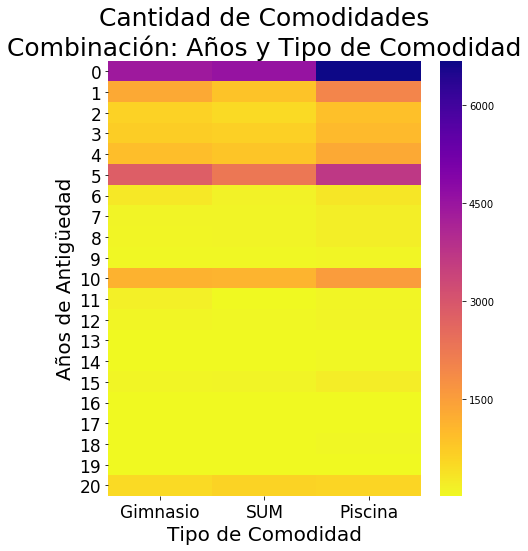

In [59]:
plt.figure(figsize=(7,8))
plot = sb.heatmap(df_comodidad_anios_propias[0:21], cmap = 'plasma_r', cbar = True)
# Un _r al final del colormap invierte el sentido.
plot.set_title('Cantidad de Comodidades\nCombinación: Años y Tipo de Comodidad',fontsize = 25)
plot.set_xlabel('Tipo de Comodidad', fontsize = 20)
plot.set_ylabel('Años de Antigüedad', fontsize = 20)
plt.xticks(fontsize = 17, rotation = 0, ha = 'center', va = 'top')
plt.yticks(fontsize = 17, rotation = 0)
plt.show()

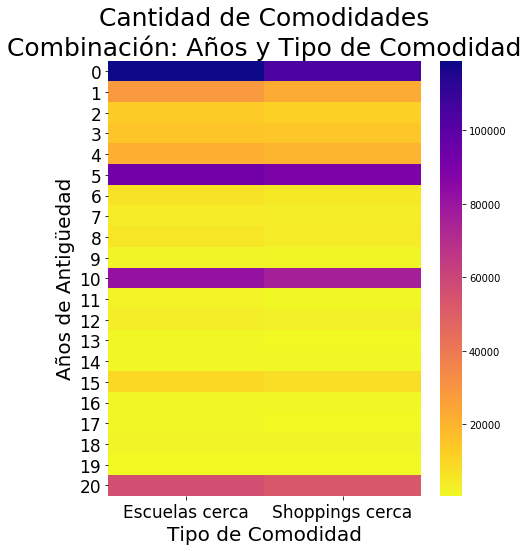

In [60]:
plt.figure(figsize=(7,8))
plot = sb.heatmap(df_comodidad_anios_compartidas[0:21]*5, cmap = 'plasma_r', cbar = True)
plot.set_title('Cantidad de Comodidades\nCombinación: Años y Tipo de Comodidad',fontsize = 25)
plot.set_xlabel('Tipo de Comodidad', fontsize = 20)
plot.set_ylabel('Años de Antigüedad', fontsize = 20)
plt.xticks(fontsize = 17, rotation = 0, ha = 'center', va = 'top')
plt.yticks(fontsize = 17, rotation = 0)
plt.show()

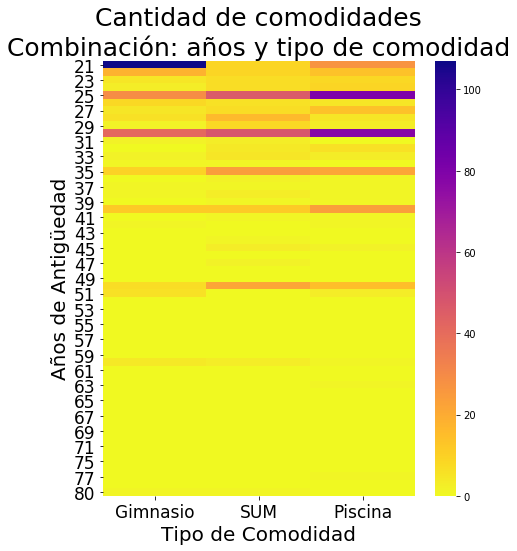

In [61]:
plt.figure(figsize=(7,8))
plot = sb.heatmap(df_comodidad_anios_propias[21:81], cmap = 'plasma_r', cbar = True)
plot.set_title('Cantidad de comodidades\nCombinación: años y tipo de comodidad',fontsize = 25)
plot.set_xlabel('Tipo de Comodidad', fontsize = 20)
plot.set_ylabel('Años de Antigüedad', fontsize = 20)
plt.xticks(fontsize = 17, rotation = 0, ha = 'center', va = 'top')
plt.yticks(fontsize = 17, rotation = 0)
plt.show()

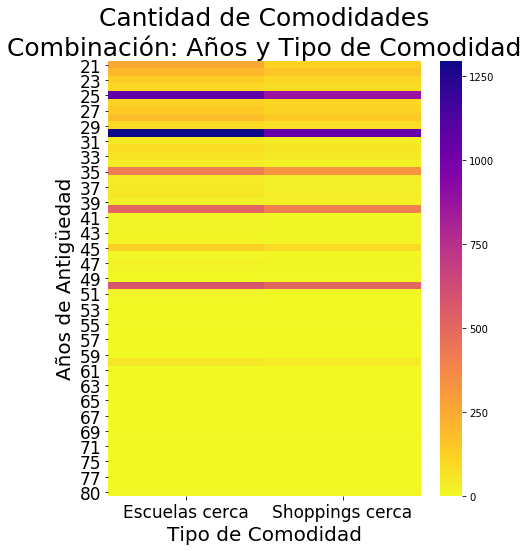

In [62]:
plt.figure(figsize=(7,8))
plot = sb.heatmap(df_comodidad_anios_compartidas[21:81], cmap = 'plasma_r', cbar = True)
plot.set_title('Cantidad de Comodidades\nCombinación: Años y Tipo de Comodidad',fontsize = 25)
plot.set_xlabel('Tipo de Comodidad', fontsize = 20)
plot.set_ylabel('Años de Antigüedad', fontsize = 20)
plt.xticks(fontsize = 17, rotation = 0, ha = 'center', va = 'top')
plt.yticks(fontsize = 17, rotation = 0)
plt.show()

In [63]:
df_comodidad = dfok[['Provincia', \
                     'TieneGimnasio', \
                     'TieneUsosMultiples', \
                     'TienePileta', \
                     'TieneEscuelasCerca', \
                     'TieneShoppingsCerca']].copy() # El copy es para diferenciarlo de dfok
# Se cambian tipos, salvo el de Provincia para detectar los casos nulos.
df_comodidad['TieneGimnasio'] = df_comodidad['TieneGimnasio'].astype(np.uint8)
df_comodidad['TieneUsosMultiples'] = df_comodidad['TieneUsosMultiples'].astype(np.uint8)
df_comodidad['TienePileta'] = df_comodidad['TienePileta'].astype(np.uint8)
df_comodidad['TieneEscuelasCerca'] = df_comodidad['TieneEscuelasCerca'].astype(np.uint8)
df_comodidad['TieneShoppingsCerca'] = df_comodidad['TieneShoppingsCerca'].astype(np.uint8)

In [64]:
# Se buscan los casos nulos y se calcula su proporción en los totales.
print('Casos nulos:')
print(df_comodidad.isnull().sum())
print('\nPropoción de casos nulos:', round(df_comodidad.isnull().sum().sum()/len(df_comodidad), 5))

Casos nulos:
Provincia              155
TieneGimnasio            0
TieneUsosMultiples       0
TienePileta              0
TieneEscuelasCerca       0
TieneShoppingsCerca      0
dtype: int64

Propoción de casos nulos: 0.00065


In [65]:
# Se remueven los casos nulos.
df_comodidad.dropna(inplace = True)

In [66]:
# Se crea un nuevo DataFrame para el countplot. Solo se guardan los casos que poseen alguna comodidad.
# Se usan los noombres de las provincias y el tipo de comodidad. Luego se toman solo los casos que sí
# poseen la comodidad. Al final los tipos de comodidad se condensan en una sola columna: Comodidad.

# Gimnasio
como_gim = df_comodidad[['Provincia', 'TieneGimnasio']]
como_gim = como_gim.loc[como_gim['TieneGimnasio'] == 1].copy()
como_gim['TieneGimnasio'].replace({1:'Gimnasio'}, inplace = True)
como_gim.rename(columns = {'TieneGimnasio': 'Comodidad'}, inplace = True)

# Salón de Usos Múltiples
como_sum = df_comodidad[['Provincia', 'TieneUsosMultiples']]
como_sum = como_sum.loc[como_sum['TieneUsosMultiples'] == 1].copy()
como_sum['TieneUsosMultiples'].replace({1:'Salón Usos Múlt.'}, inplace = True)
como_sum.rename(columns = {'TieneUsosMultiples': 'Comodidad'}, inplace = True)

# Piscina
como_pil = df_comodidad[['Provincia', 'TienePileta']]
como_pil = como_pil.loc[como_pil['TienePileta'] == 1].copy()
como_pil['TienePileta'].replace({1:'Piscina'}, inplace = True)
como_pil.rename(columns = {'TienePileta': 'Comodidad'}, inplace = True)

# Escuelas cercanas
como_esc = df_comodidad[['Provincia', 'TieneEscuelasCerca']]
como_esc = como_esc.loc[como_esc['TieneEscuelasCerca'] == 1].copy()
como_esc['TieneEscuelasCerca'].replace({1:'Escuelas cerca'}, inplace = True)
como_esc.rename(columns = {'TieneEscuelasCerca': 'Comodidad'}, inplace = True)

# Centros Comerciales cercanos
como_ccc = df_comodidad[['Provincia', 'TieneShoppingsCerca']]
como_ccc = como_ccc.loc[como_ccc['TieneShoppingsCerca'] == 1].copy()
como_ccc['TieneShoppingsCerca'].replace({1:'Centros com. cerca'}, inplace = True)
como_ccc.rename(columns = {'TieneShoppingsCerca': 'Comodidad'}, inplace = True)

# Se unen los DataFrames por la columna Comodidad.
concatenado = pd.concat([como_gim, como_sum], sort = False)
concatenado = pd.concat([concatenado, como_pil], sort = False).copy()
concatenado = pd.concat([concatenado, como_esc], sort = False).copy()
concatenado = pd.concat([concatenado, como_ccc], sort = False).copy()

In [67]:
concatenado_propias = \
    concatenado\
        .loc[(concatenado['Comodidad'] != 'Escuelas cerca') & \
             (concatenado['Comodidad'] != 'Centros com. cerca')]\
        .copy()

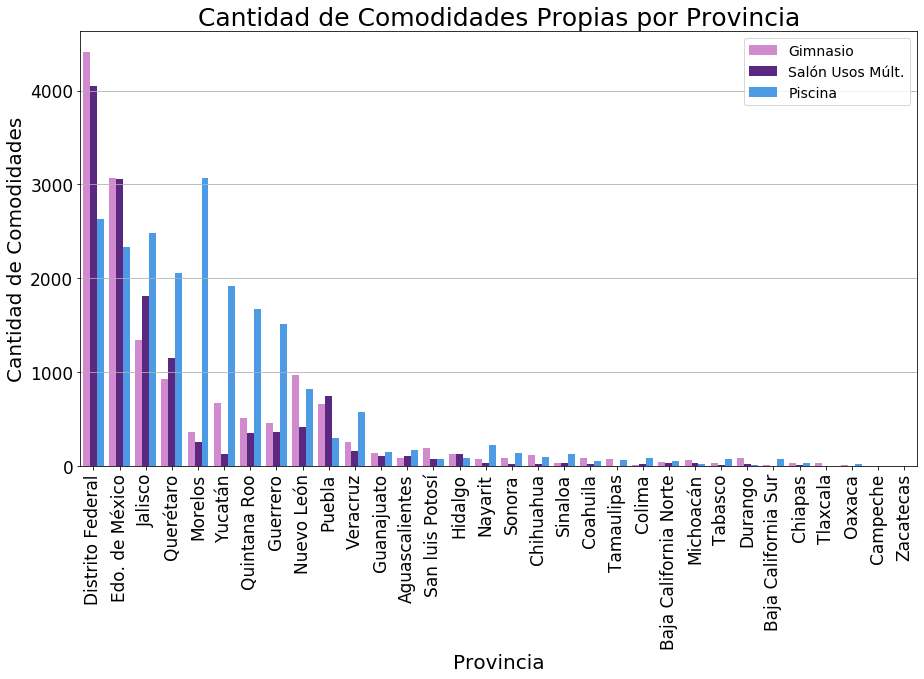

In [68]:
plt.figure(figsize = (15, 8))
g = sb.countplot(x = 'Provincia', \
                 hue = 'Comodidad', \
                 data = concatenado_propias, \
                 order = concatenado_propias['Provincia'].value_counts().index, \
                 palette = ['orchid', 'indigo', 'dodgerblue'], \
                 linewidth = 0, edgecolor = 'dimgrey', \
                 alpha = 0.9) # 'hls' 'husl'
g.set_title('Cantidad de Comodidades Propias por Provincia', fontsize=25)
g.set_xlabel('Provincia', fontsize = 20, rotation = 0)
g.set_ylabel('Cantidad de Comodidades', fontsize = 20)
plt.xticks(fontsize=17, rotation = 90, ha = 'center')
plt.yticks(fontsize=17)
plt.legend(loc = 'upper right', fontsize = 14)
plt.gca().yaxis.grid(True)
plt.show()

In [69]:
concatenado_compartidas = \
    concatenado\
        .loc[(concatenado['Comodidad'] == 'Escuelas cerca') | \
             (concatenado['Comodidad'] == 'Centros com. cerca')]\
        .copy()

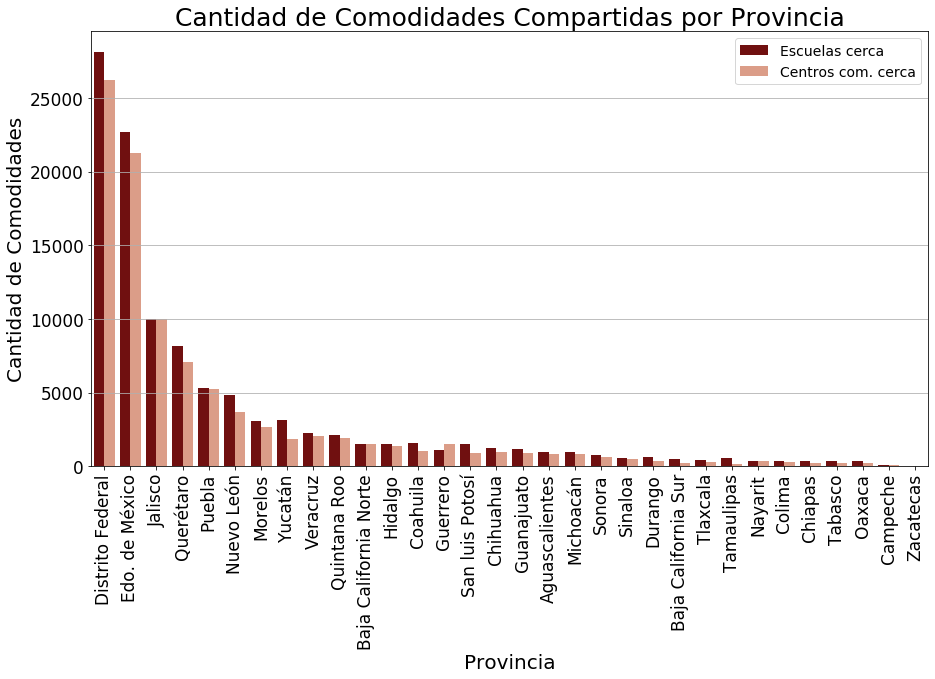

In [70]:
plt.figure(figsize = (15, 8))
g = sb.countplot(x = 'Provincia', \
                 hue = 'Comodidad', \
                 data = concatenado_compartidas, \
                 order = concatenado_compartidas['Provincia'].value_counts().index, \
                 linewidth = 0, edgecolor = 'dimgray', \
                 palette = ['maroon', 'darksalmon']) #['darkgoldenrod', 'gold'] 'hls' 'husl'
g.set_title('Cantidad de Comodidades Compartidas por Provincia', fontsize=25)
g.set_xlabel('Provincia', fontsize = 20, rotation = 0)
g.set_ylabel('Cantidad de Comodidades', fontsize = 20)
plt.xticks(fontsize=17, rotation = 90, ha = 'center')
plt.yticks(fontsize=17)
plt.legend(loc = 'upper right', fontsize = 14)
plt.gca().yaxis.grid(True)
plt.show()

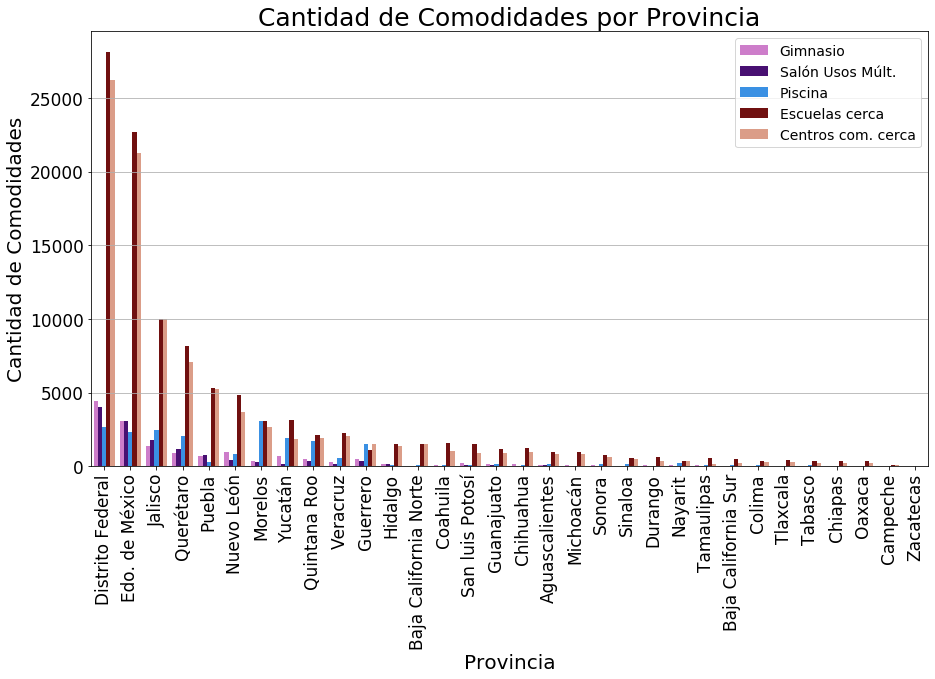

In [71]:
plt.figure(figsize = (15, 8))
g = sb.countplot(x = 'Provincia', \
                 hue = 'Comodidad', \
                 data = concatenado, \
                 order = concatenado['Provincia'].value_counts().index, \
                 palette = ['orchid', 'indigo', 'dodgerblue', 'maroon', 'darksalmon'], \
                 linewidth = 0, edgecolor = 'dimgray') # 'hls' 'husl'
g.set_title('Cantidad de Comodidades por Provincia', fontsize = 25)
g.set_xlabel('Provincia', fontsize = 20, rotation = 0)
g.set_ylabel('Cantidad de Comodidades', fontsize = 20)
plt.xticks(fontsize=17, rotation = 90, ha = 'center')
plt.yticks(fontsize=17)
plt.legend(loc = 'upper right', fontsize = 14)
plt.gca().yaxis.grid(True)
plt.show()